In [1]:
import torch
import numpy as np
from BENK import BENKDataGenerator, BENK, tau_loss, train_model
from models import sf_to_t
from funcs import gauss_func, circle_func, spiral_func
from pytorch_survival import arrs_to_torch_dev
from sksurv.ensemble import RandomSurvivalForest
import matplotlib.pyplot as plt
from IPython.display import clear_output

np.seterr(all='ignore')
np.random.seed(12345)
torch.manual_seed(12345)

# Simple example of making the survival function prediction

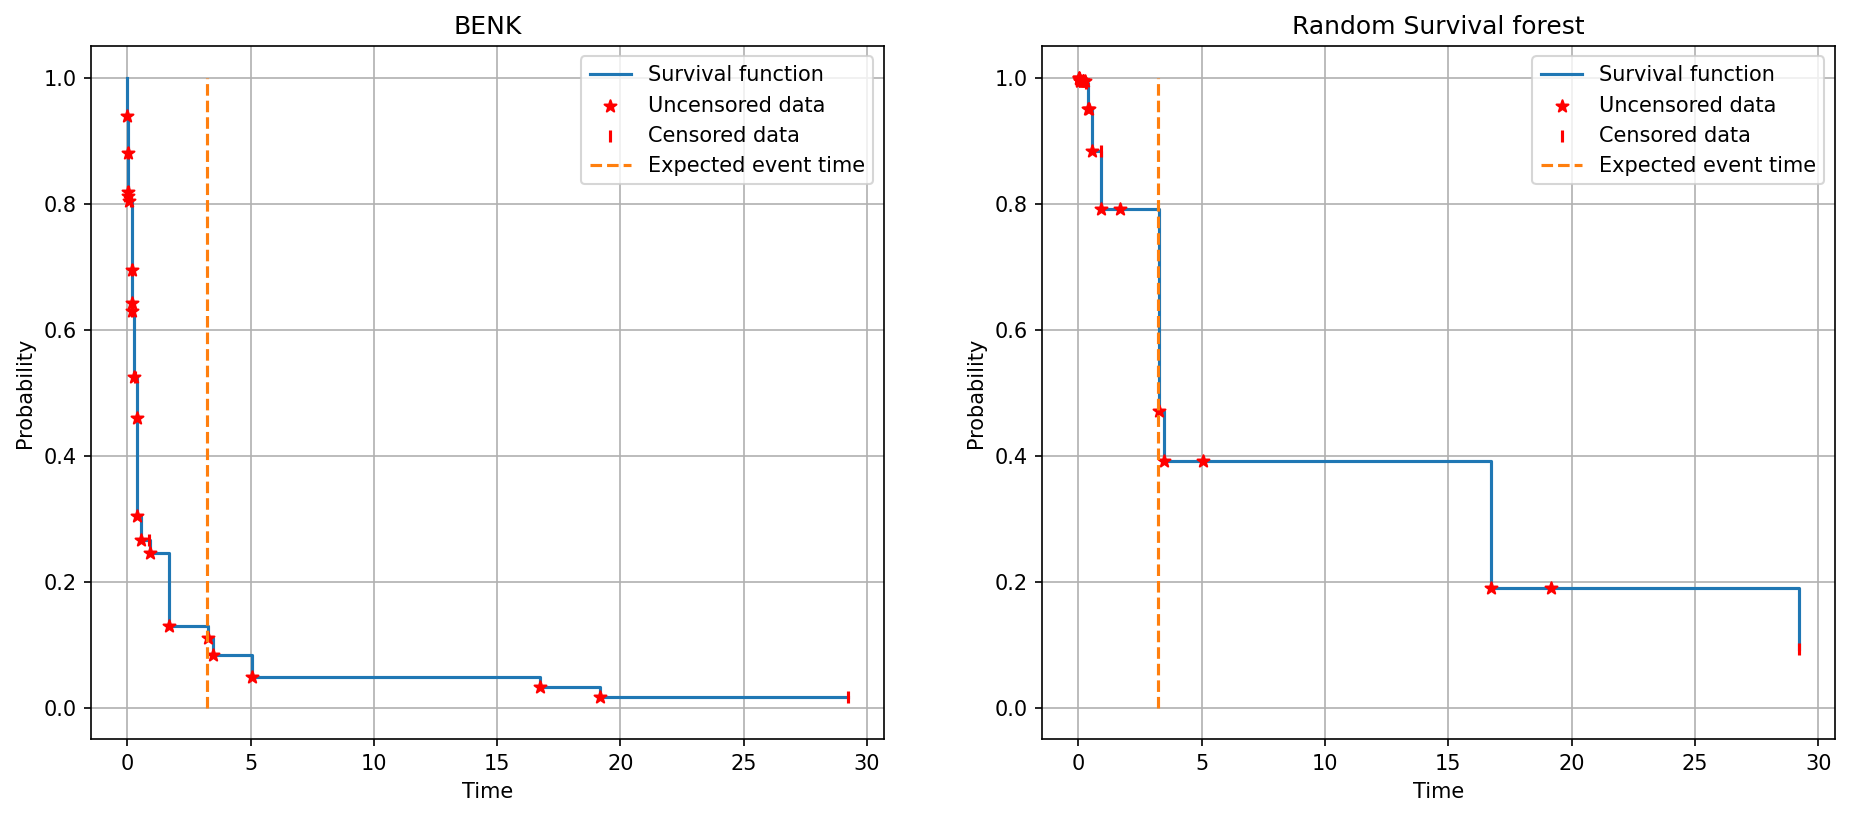

Expected event time:  3.2459
BENK predicted expected event time:  1.7883  PEHE metric (lower is better):  1.4576
RSF predicted expected event time:  10.382  PEHE metric (lower is better):  7.1361


In [2]:
# dataset initializing
feat_num = 20
func = spiral_func(feat_num, 1.6, 0.0005, 2)
train_size = 30
n = int(0.8 * train_size)
epochs = 200
benk = BENK(feat_num)
tau = np.random.uniform(0, 10, train_size)
x_train = func.calc_x(tau)
T_train = func.calc_T(tau)
delta_train = np.random.binomial(1, 0.6, train_size)
sorted_args = np.argsort(T_train)
delta_sorted = delta_train[sorted_args]
censored_sorted_mask = np.concatenate(([False], delta_sorted == 0))
uncensored_sorted_mask = np.concatenate(([False], delta_sorted == 1))
T_predict = np.concatenate(([0], T_train[sorted_args]))

# pytorch training loop
data_generator = BENKDataGenerator(x_train, T_train, delta_train, 64, n, 2)
optimizer = torch.optim.AdamW(benk.parameters(), 0.001)
train_model(data_generator, benk, tau_loss, optimizer, epochs)
clear_output()

# training of the survival forest
surv_forest = RandomSurvivalForest()
str_array = np.ndarray(shape=(T_train.shape[0]), dtype=[('censor', '?'), ('time', 'f4')])
str_array['censor'] = delta_train.astype(bool)
str_array['time'] = T_train
surv_forest.fit(x_train, str_array)

# predictions calculating
tau_p = np.random.uniform(0, 10, 1)
x_predict = func.calc_x(tau_p)
predict_label = func.calc_expected(tau_p).item()
benk_args = arrs_to_torch_dev(x_train[None, ...], T_train[None, ...], delta_train[None, ...], x_predict, T_predict[None, :])
sf_benk = benk.predict_in_points(*benk_args)
step_func_forest = surv_forest.predict_survival_function(x_predict)[0]
T_predict_forest = T_predict.copy()
T_predict_forest[-1] -= 1e-6 # to satisfy internal sksurv's forest assertions
sf_forest = step_func_forest(T_predict_forest)
benk_estim = sf_to_t(sf_benk, T_predict).item()
forest_estim = sf_to_t(sf_forest[None, :], T_predict).item()

# drawing
fig, axes = plt.subplots(1, 2, figsize=(15, 6), dpi=150)
for ax, sf, title in zip(axes, [sf_benk.ravel(), sf_forest], ['BENK', 'Random Survival forest']):
    ax.plot(T_predict, sf, ds='steps-post', label='Survival function')
    ax.scatter(T_predict[uncensored_sorted_mask], sf[uncensored_sorted_mask], marker='*', c='r', label='Uncensored data', zorder=10)
    ax.scatter(T_predict[censored_sorted_mask], sf[censored_sorted_mask], marker='|', c='r', label='Censored data', zorder=10)
    ax.plot([predict_label] * 2, [0, 1], '--', label='Expected event time', zorder=20)
    ax.set_xlabel('Time')
    ax.set_ylabel('Probability')
    ax.set_title(title)
    ax.grid()
    ax.legend()
plt.show()

print('Expected event time: ', round(predict_label, 4))
print('BENK predicted expected event time: ', round(benk_estim, 4), ' PEHE metric (lower is better): ', round(abs(predict_label - benk_estim), 4))
print('RSF predicted expected event time: ', round(forest_estim, 4), ' PEHE metric (lower is better): ', round(abs(predict_label - forest_estim), 4))

# The experiment with the treatment effect research, similar with one in the article. 

Control sample size: 300

Treatment sample size: 60

Test sample size: 1000

Censored part: 33%

Dimension of the feature space: 10

In [3]:
import  pytorch_survival as ps
from collections import defaultdict
import re

# creating dictionary for the results
ps.res_dict = defaultdict(list)
# preparing functions
cnt_func = circle_func(ps.m, ps.t_bnds, ps.b_cnt, ps.l_cnt, ps.nu_cnt)
trt_func = circle_func(ps.m, ps.t_bnds, ps.b_trt, ps.l_trt, ps.nu_trt)
# doing the experiment
data_dict = ps.make_treat_set(cnt_func, trt_func, ps.t_bnds, ps.censored_part,
                               ps.cnt_size, ps.trt_size, ps.test_size, ps.val_size)
ps.exp_iter(data_dict, True, None)
clear_output()
# printing the results
pattern = re.compile(r'CATE PEHE')
print('We use the PEHE metric, lower is better')
print()
for key, val in ps.res_dict.items():
    if 'PEHE' in key:
        if re.search(pattern, key):
            print(key.replace('Kernel', 'BENK', 1) + ':', round(val[0], 5))
print()
print("""Note that "Spoiler" models don't take part in the experiments
as they were trained unfairly. They are needed to explore the
lower error bound in the experiment.
""")

We use the PEHE metric, lower is better

BENK CATE PEHE: 1.82092
T-SF CATE PEHE: 3.33435
S-SF CATE PEHE: 5.40588
X-SF CATE PEHE: 7.40928
T-NW CATE PEHE: 4.42183
S-NW CATE PEHE: 5.15163
X-NW CATE PEHE: 4.69632
T-Cox CATE PEHE: 6.36544
S-Cox CATE PEHE: 5.57983
X-Cox CATE PEHE: 4.56052
T-Spoiler CATE PEHE: 1.30194
S-Spoiler CATE PEHE: 1.40537

Note that "Spoiler" models don't take part in the experiments
as they were trained unfairly. They are needed to explore the
lower error bound in the experiment.

